In [15]:
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [16]:
wth = pd.read_csv("weatherHistory.csv")

In [17]:
wth.drop_duplicates(inplace=True)

In [23]:
dates = pd.DataFrame(wth["Formatted Date"].apply(lambda x: x[:10]).value_counts())
down_index = dates.loc[dates["Formatted Date"] < 24].index
for i in down_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]
upper_index = dates.loc[dates["Formatted Date"] > 24].index
for i in upper_index:
    wth = wth[~(wth["Formatted Date"].str.startswith(i))]

In [24]:
wth.dropna(inplace=True)

In [25]:
wth.drop("Loud Cover", axis=1, inplace=True)
wth.drop("Apparent Temperature (C)", axis=1, inplace=True)
wth.drop("Daily Summary", axis=1, inplace=True)
wth.drop("Summary", axis=1, inplace=True)
wth.drop(wth[wth["Pressure (millibars)"] < 1].index, inplace=True)


wth["hour"] = wth["Formatted Date"].apply(lambda x: x[10:13])
wth["hour"] = wth["hour"].astype(int)


wth["Month"] = wth["Formatted Date"].apply(lambda x: x[5:7])
wth["Month"] = wth["Month"].astype(int)
   
                                   
wth["DayOfYear"] = wth["Formatted Date"].apply(lambda x: x[:10])
wth['DayOfYear'] = wth['DayOfYear'].astype('datetime64[ns]')
wth["DayOfYear"] = wth["DayOfYear"].apply(lambda x: x.timetuple().tm_yday)
                                   
                                   
precip_mask = {
    "rain" : 0,
    "snow" : 1
}

wth.replace({"Precip Type": precip_mask}, inplace=True)
                                   

wth.dropna(how="all", inplace=True)
wth = wth.drop("Formatted Date", axis =1)

# Future forward selection

In [28]:
model = LinearRegression()
summary_df = pd.DataFrame()
X_train, X_test, y_train, y_test = train_test_split(wth.drop("Temperature (C)", axis=1), wth["Temperature (C)"], test_size=0.2)
columns = []
for i in range(1, 11):
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    cols = X_train.columns[rfe.support_]
    columns.append(cols)
    


In [29]:
#Based on rfe.fit, we create a list of variables in the order in which they were selected by the model.
values_dict = {
    "Humidity" : 0,
    "Precip Type": 0,
    "Pressure (millibars)" : 0,
    "Wind Speed (km/h)" : 0,
    "Wind Bearing (degrees)" : 0,
    "Visibility (km)" : 0,
    "hour" : 0,
    "Month" : 0,
    "DayOfYear" : 0,
    
}

for idx in columns:
    for value in idx:
        values_dict[value] += 1
        

columns_by_imp = list(dict(sorted(values_dict.items(), key=lambda x: x[1])))
columns_by_imp.reverse()

In [30]:
#We check how the cost function changes for different tree depths and different numbers of variables added to the model
for z in range(5, 10):
    for j in range(4, 6):
        poly = PolynomialFeatures(degree=j)
        X_train, X_test, y_train, y_test = train_test_split(wth[columns_by_imp[:z]], wth["Temperature (C)"], test_size=0.2)
        X_train = poly.fit_transform(X_train)
        X_test = poly.fit_transform(X_test)
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        summary_df = pd.concat([summary_df, pd.DataFrame({"mse": [mse], "degree" : j, "amount of values" : z}
                                                        )])

In [31]:
summary_df.sort_values("mse")  #hyperparameters degree: 5, values 9

,mse,degree,amount of values
0,7.909330,5,9
0,8.009071,4,9
0,8.370242,5,8
0,8.554149,4,8
0,9.480125,5,7
0,9.531649,4,7
0,10.348509,5,6
0,10.594719,4,6
0,10.682702,4,5
0,10.829072,5,5


In [32]:
poly = PolynomialFeatures(degree=5)
X_train, X_test, y_train, y_test = train_test_split(wth.drop("Temperature (C)", axis=1), wth["Temperature (C)"], test_size=0.2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [33]:
print(f"Mse: {mse}, Mae: {mse**(1/2)}")

Mse: 8.16778573292139, Mae: 2.8579338223481296


<AxesSubplot:xlabel='Temperature (C)', ylabel='Count'>

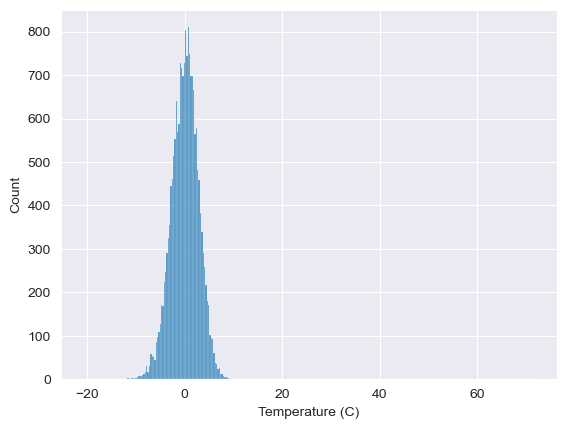

In [34]:
sns.histplot(y_test - y_pred)

<AxesSubplot:ylabel='Temperature (C)'>

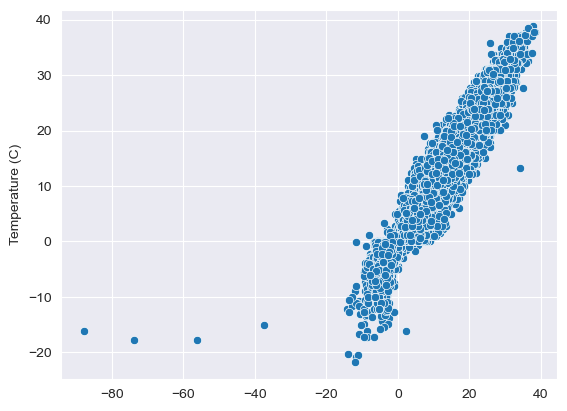

In [35]:
sns.scatterplot(x=y_pred, y=y_test)

# The model works satisfactorily, with its only drawback being a few very inaccurate predictions.
